# Compare two models

This notebook compares two trained models.

In [80]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/'

#version 1
model_1 = f'{root}V15_2016_2/'
model_2 = f'{root}V20_2016_2/'
model_3 = f'{root}V20_2016_X2/'

#version 2
model_1 = f'{root}V15_2016_2_V2/'
model_2 = f'{root}V20_2016_2_V2/'
model_3 = f'{root}V20_2016_X2_V2/'




# Predictions

In [76]:
import pandas as pd
def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
        
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())
    # print ('------------------------------------ERA---------------------------------------------------')
    # print("Mean/Median/Std prediction bias:", df['ERA_predicion_bias'].mean(), df['ERA_predicion_bias'].median(),df['ERA_predicion_bias'].std())
    # print("Mean/Median/Std prediction error:", df['ERA_predicion_error'].mean(), df['ERA_predicion_error'].median(),df['ERA_predicion_error'].std())
    # print ('-------------------------------------------------------------------------------------------')

    
    return df

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




        
        
        
def global_plot(df,z,projection,vmin,vmax,cmap,absolute_values,logscale,title,markersize,savefig):
    
    
        
       # ccrs.Robinson()
        
    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=projection)
    cax = fig.add_axes([0.32, 0.11, 0.4, 0.0125])

    #Get data
    try:
        x = df.longitude
        y = df.latitude
    except: #different sources call lat/lon different things
        x = df.longitude_ERA
        y = df.latitude_ERA

    z1 = df[z]
    if absolute_values:
        z1 = abs(z1)
        if vmin < 0:
            vmin = 0 # dont need negative vmins if plotting absolute values
    
    
    #Normalize, colorbars
    if vmin is None:
        vmin = min(z1)
    if vmax is None:
        vmax = max(z1)
        

     #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    
    
    
    
    
    
    #Scatter points
    sc = ax.scatter(x,y,transform=ccrs.PlateCarree(), #Always PlateCarree
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=30)
    cax.set_xlabel(r'$\delta$K',fontsize=34)

    ax.set_title(title)    
    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    #ax.set_xlim(-180,180)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   
        
        
        
        
            

In [77]:
predictions_1 = load_predictions(model_1)
predictions_2 = load_predictions(model_2)
predictions_3 = load_predictions(model_3)



----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.06721186 0.20108032 4.0190535
Mean/Median/Std prediction error: 2.9916244 2.283081 2.6846745
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.05126155 0.20895386 3.9501467
Mean/Median/Std prediction error: 2.9394135 2.2425537 2.639345
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.075379044 0.20806885 3.9549034
Mean/Median/Std prediction error: 2.9439828 2.244751 2.641957


In [21]:
yearly_averaged_predictions_1 = predictions_1.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
yearly_averaged_predictions_2 = predictions_2.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
yearly_averaged_predictions_3 = predictions_2.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()

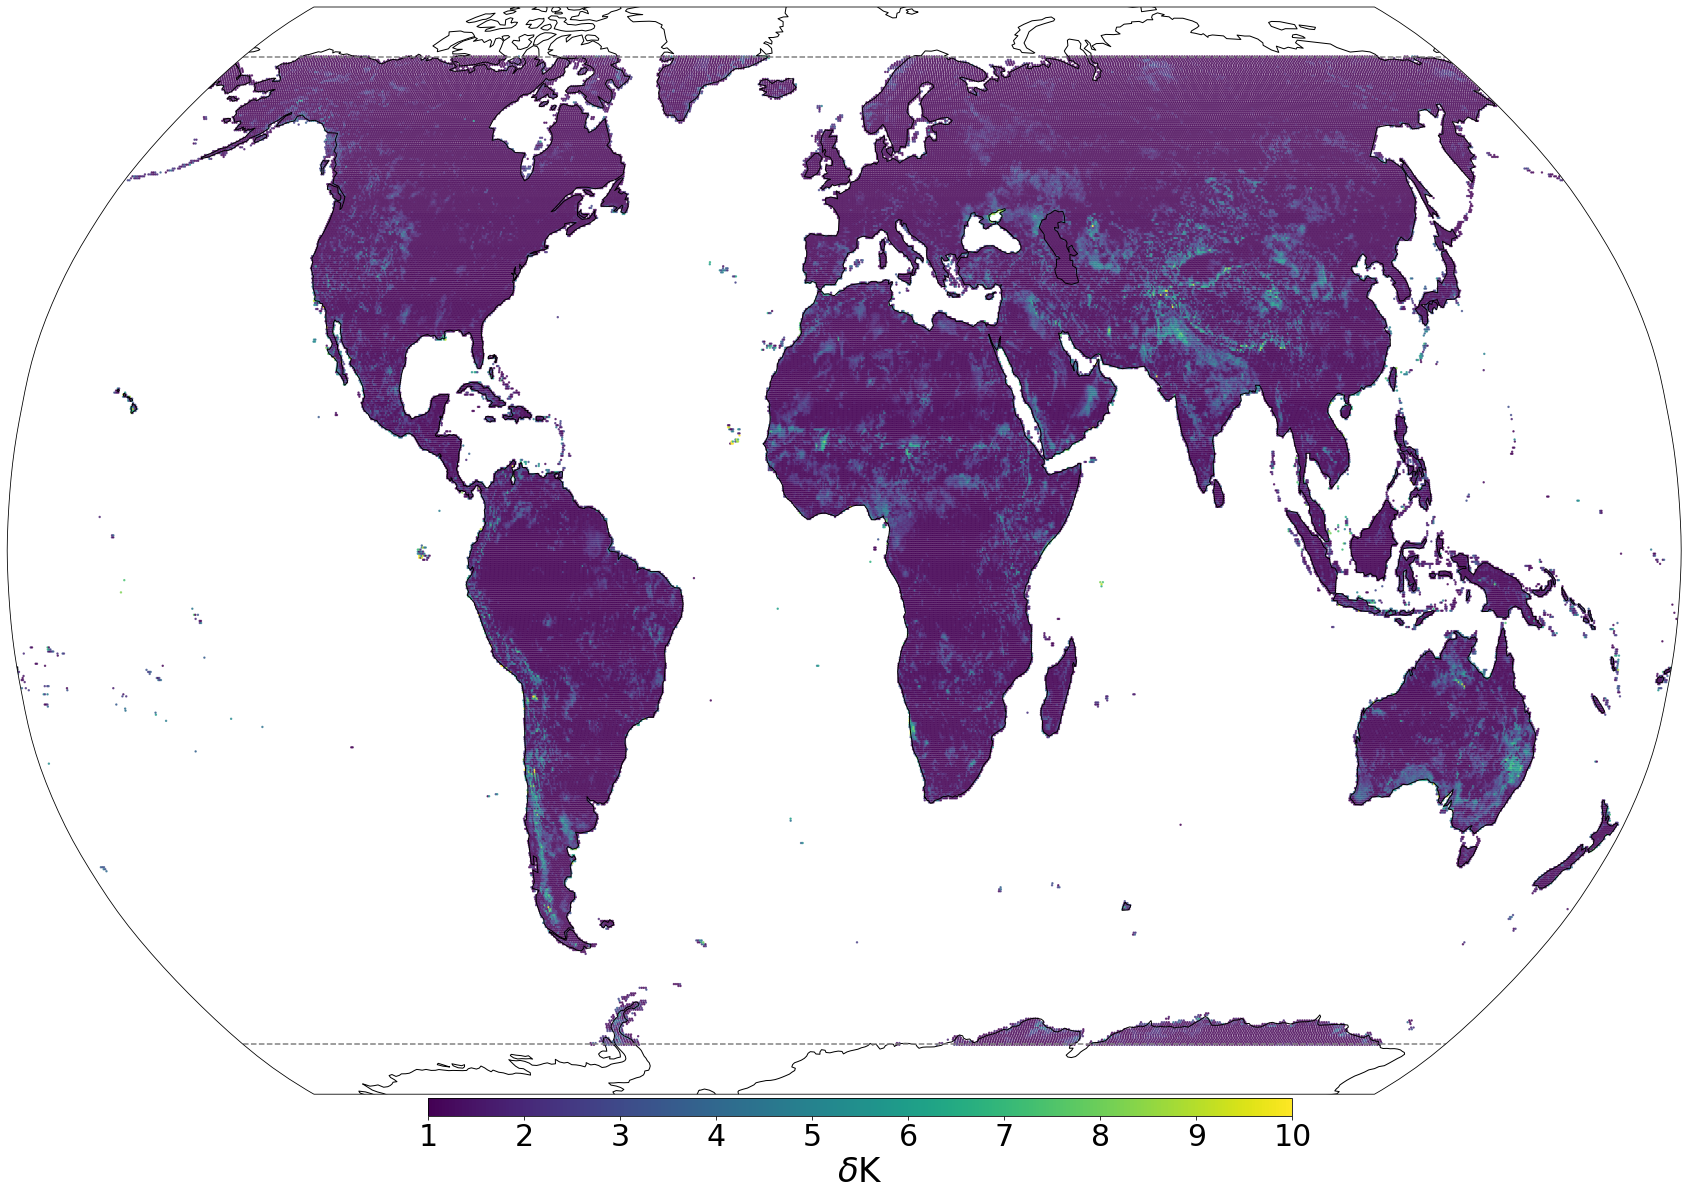

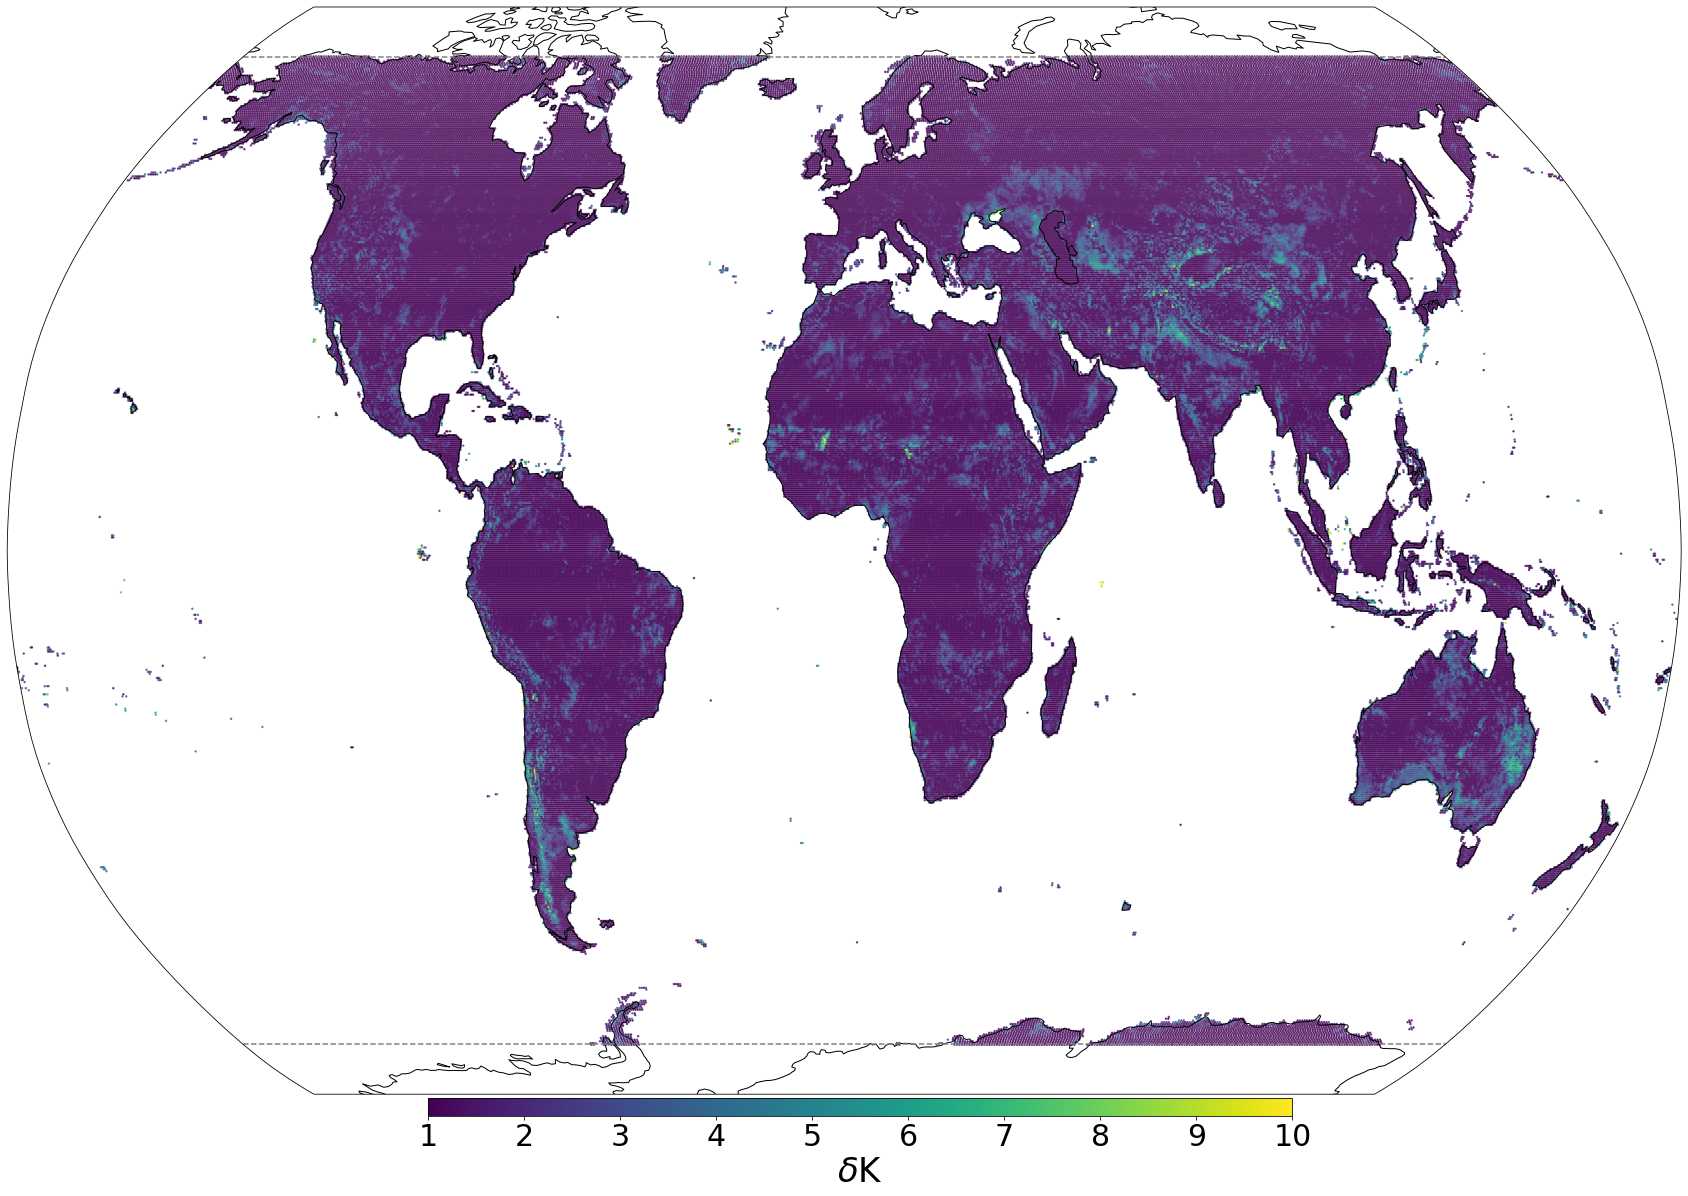

In [22]:
global_plot(yearly_averaged_predictions_1,
            'model_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title=None,
            markersize=2,
            savefig=None)


global_plot(yearly_averaged_predictions_2,
            'model_predicion_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title=None,
            markersize=2,
            savefig=None)


# Histogram of errors

    


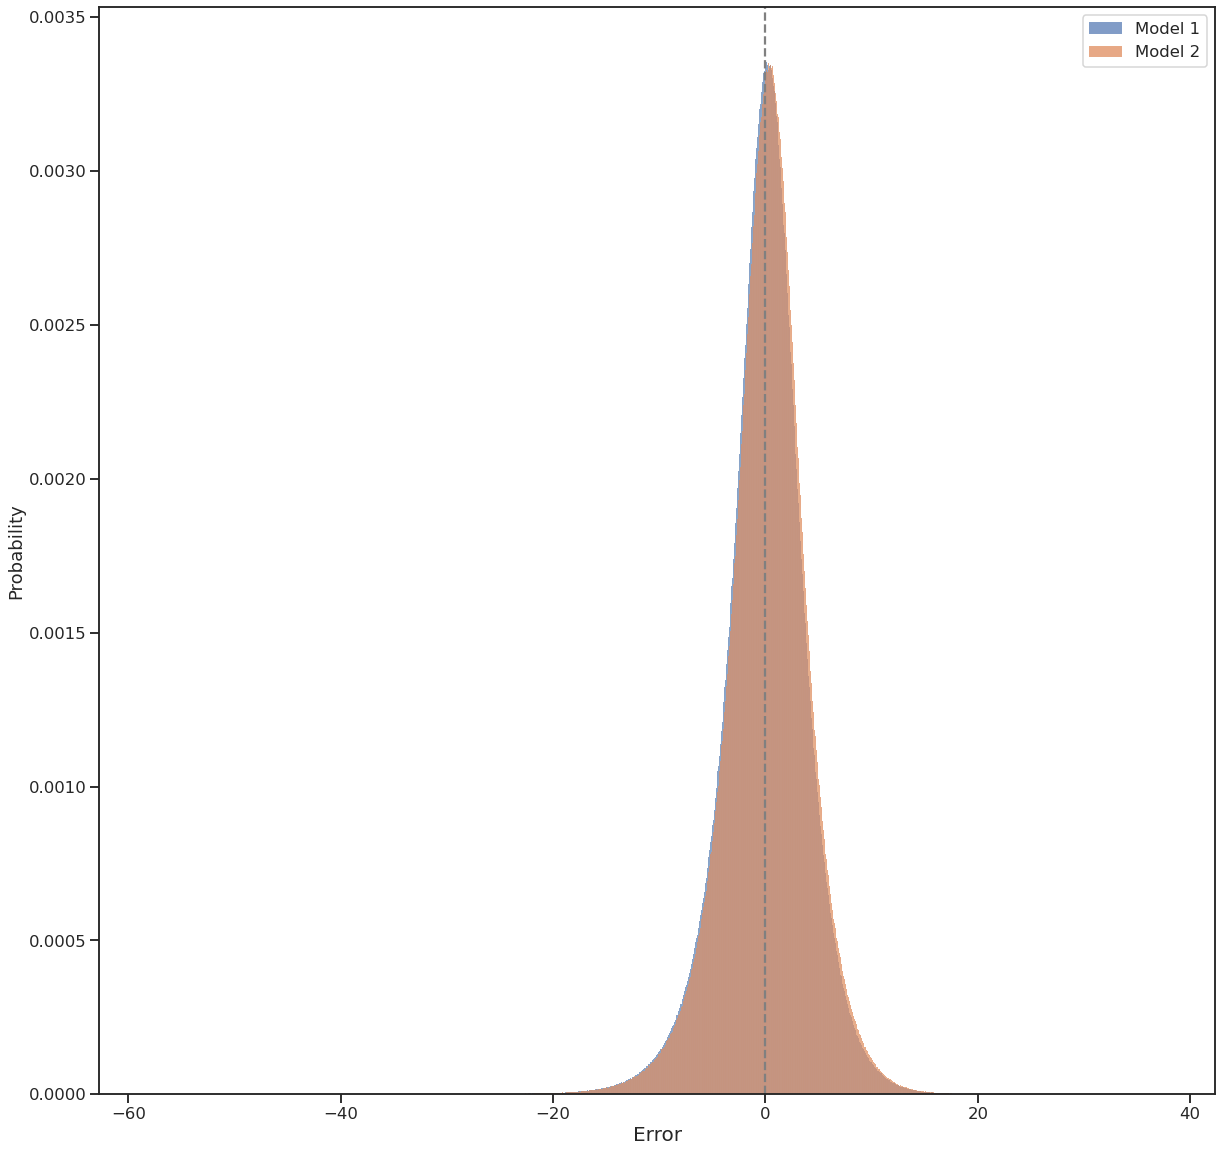

CPU times: user 2min 20s, sys: 0 ns, total: 2min 20s
Wall time: 2min 20s


In [26]:
%%time


import seaborn as sns
#Plot distribution of errors
#This is quite slow, ~1-2 mins

#Setup plot env
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )


#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))






sns.histplot(predictions_1['model_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='Model 1')
sns.histplot(predictions_2['model_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C1',label='Model 2')

# Config
ax1.set_xlabel('Error', fontsize = 20)
ax1.legend().set_title(None)
ax1.axvline(0,c='0.5', linestyle='--')




plt.show()


---


# Appendix

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import json





def plot_training_history(model):
    
    print (model)


    with open(model+'training_history.json') as f:
        d = json.load(f)

        training_loss = d['loss'][1:]
        validation_loss = d['val_loss'][1:]
        epochs = np.arange(len(training_loss))
        print ('Number of epochs:', len(epochs))
        print ('Minimum training loss:', min(training_loss))
        print('Minimum validation loss:', min(validation_loss))

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        plt.plot(epochs,validation_loss, label='validation loss')
        plt.legend()
        

        
        
def get_model_settings(model):
    
    
    with open(model+'configuration.json') as f:
        config=json.load(f)
        display(config['train'])
    
    print('----------------------------------------------------')


/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_2_V2/
Number of epochs: 146
Minimum training loss: 16.23744010925293
Minimum validation loss: 16.15116310119629
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_2_V2/
Number of epochs: 212
Minimum training loss: 15.759617805480957
Minimum validation loss: 15.626704216003418
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_X2_V2/
Number of epochs: 43
Minimum training loss: 15.763842582702637
Minimum validation loss: 15.62932300567627


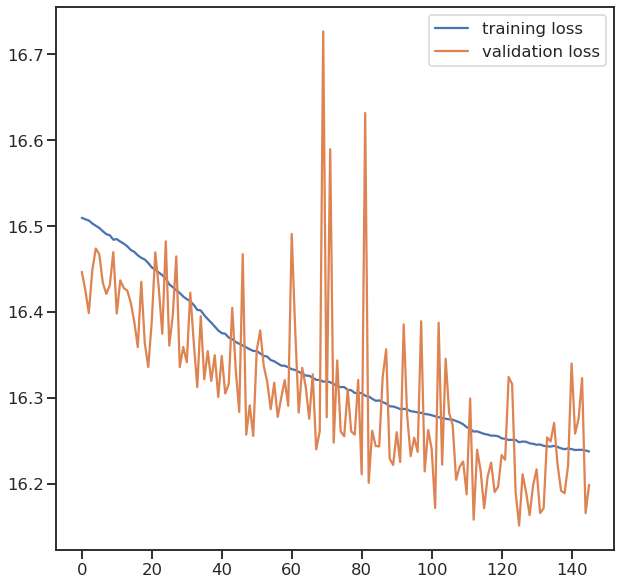

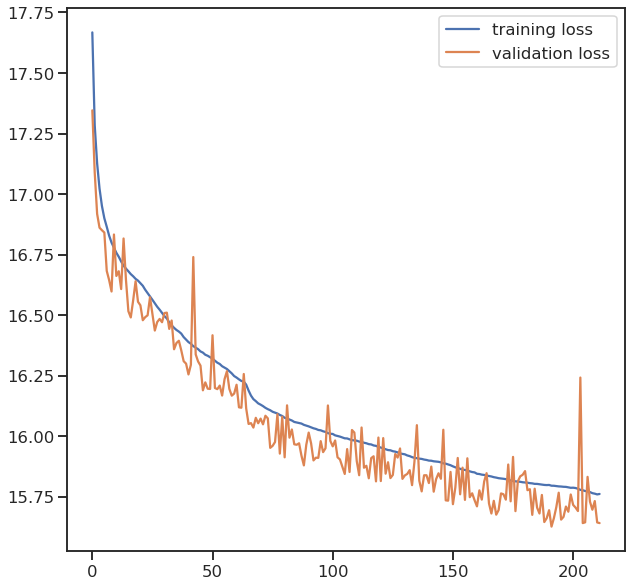

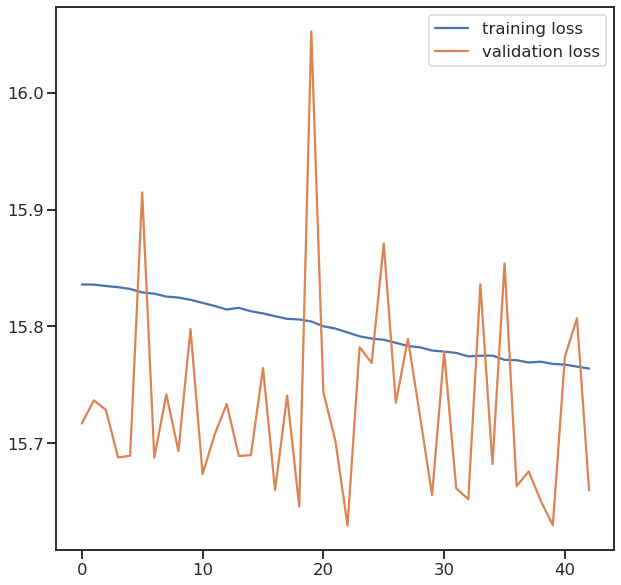

In [81]:
plot_training_history(model_1)
plot_training_history(model_2)
plot_training_history(model_3)

In [79]:
get_model_settings(model_1)
get_model_settings(model_2)
get_model_settings(model_3)

{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_MLS.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2017_MLS.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  't2m',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'd2m',
  'fal',
  'skt',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15'],
 'batch_size': 1024,
 'epochs': 200,
 'number_of_hidden_layers': 4,
 'nodes_per_layer': [None, None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.0003,
 'loss': 'mse',
 'metrics': ['accuracy'],
 'path_to_trained_models': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/',
 'model_nam

----------------------------------------------------


{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_MLS.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2017_MLS.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  't2m',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'd2m',
  'fal',
  'skt',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15',
  'sdor_v20',
  'cvl_v20',
  'lsm_v20',
  'isor_v20',
  'cvh_v20',
  'si10_v20',
  'anor_v20',
  'cl_v20',
  'dl_v20',
  'z_v20',
  'slor_v20'],
 'batch_size': 1024,
 'epochs': 600,
 'number_of_hidden_layers': 4,
 'nodes_per_layer': [None, None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.0003,
 'loss': 'mse',
 'metrics': ['accuracy'],


----------------------------------------------------


{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_MLS.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2017_MLS.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  't2m',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'd2m',
  'fal',
  'skt',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15',
  'sdor_v20',
  'cvl_v20',
  'lsm_v20',
  'isor_v20',
  'cvh_v20',
  'si10_v20',
  'anor_v20',
  'cl_v20',
  'dl_v20',
  'z_v20',
  'slor_v20',
  'clake_monthly_value',
  'cl_saline'],
 'batch_size': 1024,
 'epochs': 600,
 'number_of_hidden_layers': 4,
 'nodes_per_layer': [None, None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.0003,
 '

----------------------------------------------------


----

## Explore weird point near Caspian Sea

In [50]:
lat = 45.386399166804864
lon = 52.5
Caspian1 = predictions_1.query(f'latitude_ERA == {lat} & longitude_ERA == {lon}')
Caspian2 = predictions_2.query(f'latitude_ERA == {lat} & longitude_ERA == {lon}')
Caspian3 = predictions_3.query(f'latitude_ERA == {lat} & longitude_ERA == {lon}')

In [51]:
Caspian1['model'] = 'V15'
Caspian2['model'] = 'V20'
Caspian3['model'] = 'V20X'

/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [53]:
Caspian = pd.concat([Caspian1,Caspian2,Caspian3])

In [54]:
Caspian['month'] = pd.DatetimeIndex(Caspian.time).month
Caspian['day'] = pd.DatetimeIndex(Caspian.time).date

In [56]:
Caspian=Caspian.reset_index()

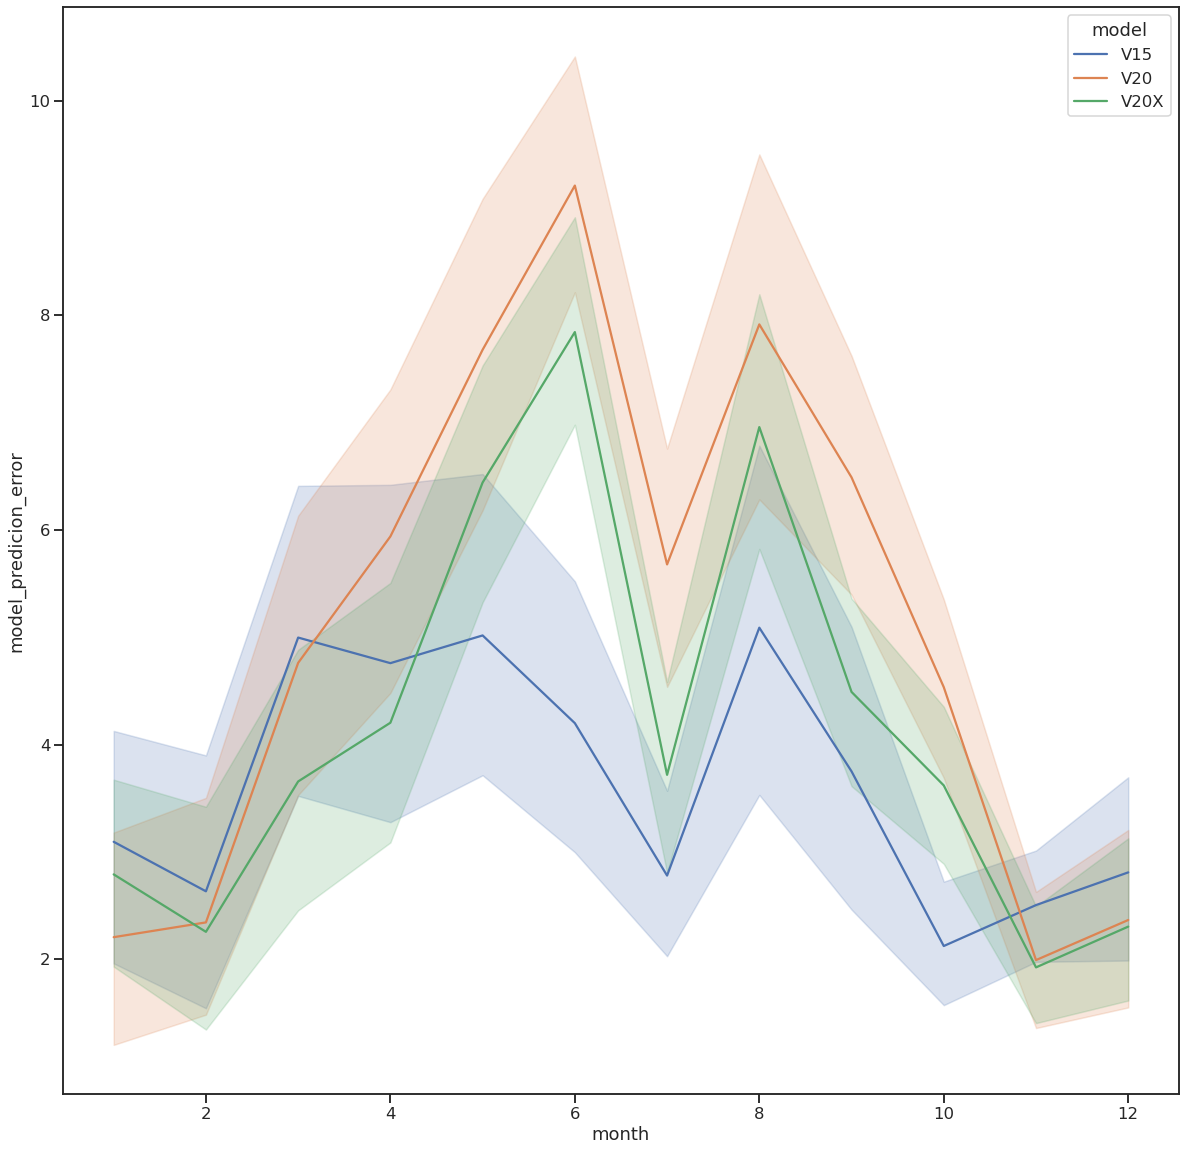

In [59]:
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
p1 = sns.lineplot(data=Caspian, x="month", y='model_predicion_error',hue='model',ax=ax1,markers=True)


In [60]:
Caspian

,index,latitude_ERA,longitude_ERA,time,MODIS_LST,skt_unnormalised,number_of_modis_observations,predictions,model_predicion_bias,model_predicion_error,ERA_predicion_bias,ERA_predicion_error,model,month,day
0,341718,45.386399,52.5,2019-01-04 10:00:00,270.303528,273.854340,51,270.742889,-0.439362,0.439362,-3.550812,3.550812,V15,1,2019-01-04
1,1407192,45.386399,52.5,2019-01-15 10:00:00,275.327667,273.101013,84,270.757355,4.570312,4.570312,2.226654,2.226654,V15,1,2019-01-15
2,1504490,45.386399,52.5,2019-01-16 10:00:00,272.732666,273.012390,37,275.034546,-2.301880,2.301880,-0.279724,0.279724,V15,1,2019-01-16
3,1792700,45.386399,52.5,2019-01-19 10:00:00,274.659027,272.148682,48,269.860657,4.798370,4.798370,2.510345,2.510345,V15,1,2019-01-19
4,1988667,45.386399,52.5,2019-01-21 10:00:00,274.510284,273.150177,94,270.087433,4.422852,4.422852,1.360107,1.360107,V15,1,2019-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2241638,45.386399,52.5,2019-12-23 10:00:00,274.015472,274.828857,87,274.441010,-0.425537,0.425537,-0.813385,0.813385,V20X,12,2019-12-23
764,2344403,45.386399,52.5,2019-12-24 10:00:00,269.995697,274.138306,5,274.732452,-4.736755,4.736755,-4.142609,4.142609,V20X,12,2019-12-24
765,2449350,45.386399,52.5,2019-12-25 10:00:00,276.555145,274.266693,86,275.509369,1.045776,1.045776,2.288452,2.288452,V20X,12,2019-12-25
766,2758650,45.386399,52.5,2019-12-28 10:00:00,275.065216,274.314301,100,273.848785,1.216431,1.216431,0.750916,0.750916,V20X,12,2019-12-28


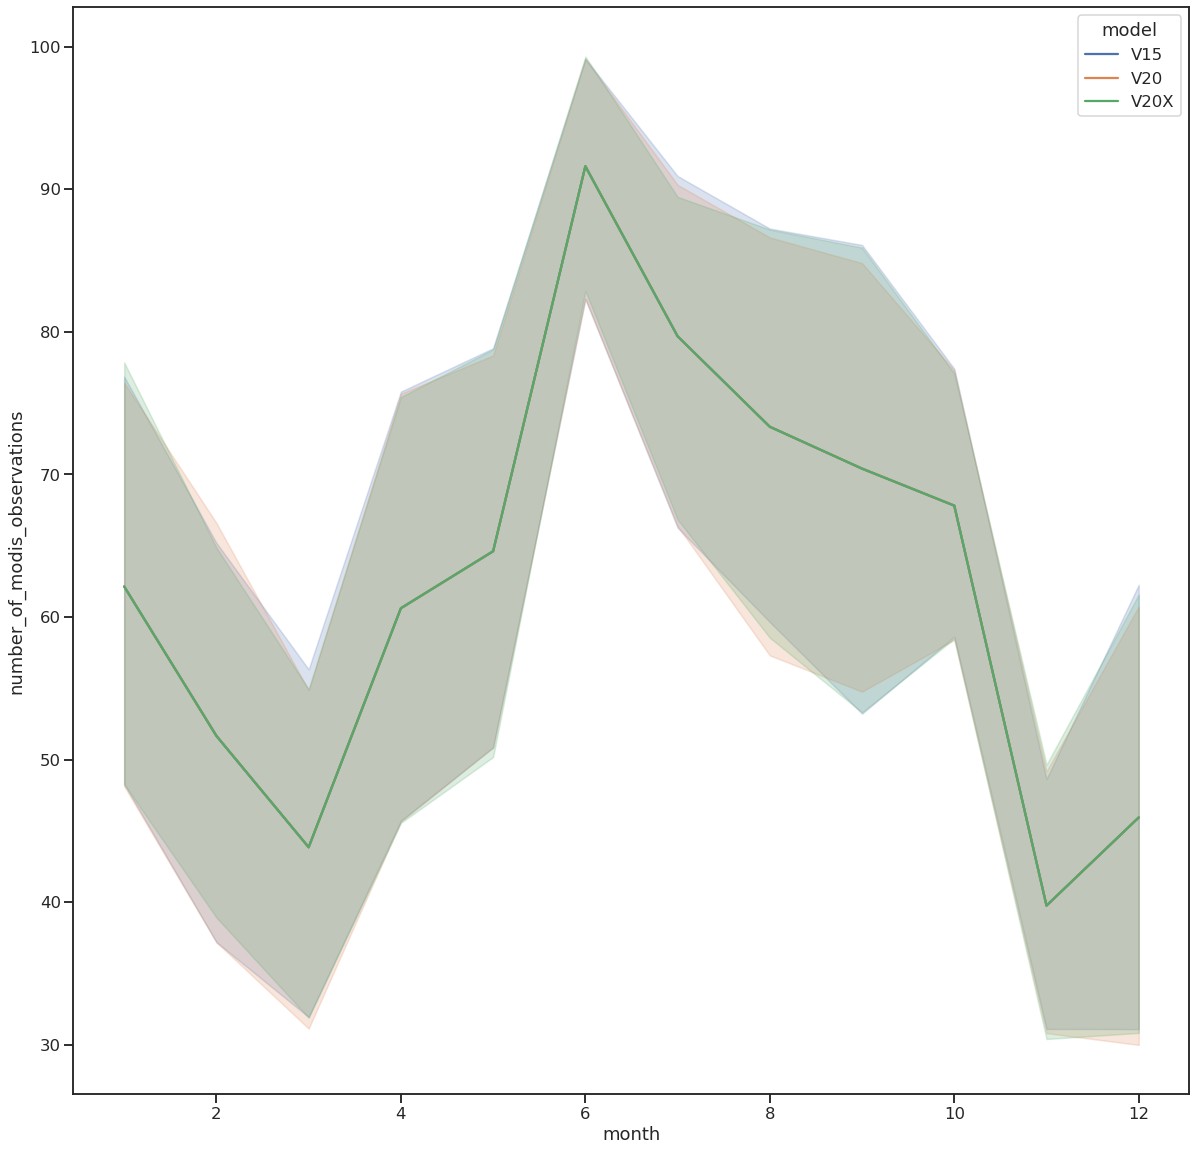

In [61]:
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
p1 = sns.lineplot(data=Caspian, x="month", y='number_of_modis_observations',hue='model',ax=ax1,markers=True)


In [ ]:
def plot_timeseries(df):

    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))

    p = sns.lineplot(data=df, x="month", y='predicion_error',hue='model', style='model', ci=99,ax=ax1,markers=True)
    #p = sns.lineplot(data=df, x="month", y='predicion_error',hue='model', style='model', ci=None,ax=ax1,markers=True)

    ax1.set_xlabel("Month",fontsize=34)
    ax1.set_ylabel("Mean Prediction Error (K)",fontsize=34)
    ax1.legend().set_title(None)
    
    ax1.tick_params(labelsize=30)
    #cax.set_xlabel(r'$\delta$K',fontsize=34)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)    
    

In [64]:
df = pd.read_parquet('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_MLS.parquet')

KeyboardInterrupt: 